In [14]:
import numpy as np
%matplotlib inline
import Corrfunc
import glob
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import utils
import plotter

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

import cmasher as cmr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
def load_data(cat_tag, cf_tag, Nrealizations=100, return_amps=False):
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    xis = []
    amps = []
    n_converged = 0

    for Nr in range(Nrealizations):

        if 'baoiter' in cf_tag:
            fn_pattern = f"cf{cf_tag}_converged_*{cat_tag}_rlz{Nr}.npy"
            for cf_fn in glob.glob(f'{result_dir}/{fn_pattern}'):
                r_avg, xi, amp, _, _ = np.load(cf_fn, allow_pickle=True)
                n_converged +=1
                break #should only be 1 match; but probs better way to do this
            amps.append(amp)
        else:
            cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tag, cat_tag, Nr)
            r_avg, xi, amps = np.load(cf_fn, allow_pickle=True)
        
        rs.append(r_avg)
        xis.append(xi)
        
    if return_amps:
        return rs, xis, amps
    else:
        return rs, xis

In [5]:
def plot_cf_err(rs, cf_arrs, r_true, cf_true, labels, colors, err=False, xlim=None, errlim=None, cont=True, bases=None):
    
    if np.array(rs).ndim == 1:
        rs = [rs]
    if np.array(cf_arrs).ndim == 2:
        cf_arrs = np.array([cf_arrs])
    
    cfs_mean = []
    error_regions = []
    for cfs in cf_arrs:
        mean = np.mean(cfs, axis=0)
        cfs_mean.append(mean)
        std = np.std(cfs, axis=0)
        error_regions.append([mean-std, mean+std])
    
    ax = plotter.plot_cf_cont(rs, cfs_mean, r_true, cf_true, labels, colors, error_regions=error_regions, 
                         err=err, xlim=xlim, errlim=errlim, cont=cont, bases=bases)
    return ax

In [6]:
def plot_continuous(cat_tag, cf_tags, Nrealizations=100, colors=None, labels=None, err=True, errlim=None, 
                    cont=True, show_bases=True, xlim=None, peak_fit=False, bws=[], r_widths=[], r_max_true=None):
    
    if colors is None:
        colors = ['lime','blue', 'cyan', 'magenta', 'purple']
    if labels is None:
        labels = [f"{tag.split('_')[1]}, bin width {tag.split('bw')[-1]}" for tag in cf_tags]
    if xlim is None:
        xlim = [40.0, 148.0]
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    r_arrs = []
    cf_arrs = []
    if show_bases:
        bases = []

    for i in range(len(cf_tags)):
        cf_tag = cf_tags[i]
        xis = []
        rarr = []
        n_converged = 0

        for Nr in range(Nrealizations):
            
            if 'baoiter' in cf_tags[i]:
                fn_pattern = f"cf{cf_tag}_converged_*{cat_tag}_rlz{Nr}.npy"
                for cf_fn in glob.glob(f'{result_dir}/{fn_pattern}'):
                    #print(cf_fn)
                    r_avg, xi, amps, _, _ = np.load(cf_fn, allow_pickle=True)
                    #print("C:", amps[4])
                    n_converged +=1
                    break #should only be 1 match; but probs better way to do this
            else:
                cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tag, cat_tag, Nr)
                r_avg, xi, amps = np.load(cf_fn, allow_pickle=True)
            
            rarr.append(r_avg)
            xis.append(xi)
        rs.append(r_avg)
        r_arrs.append(rarr)
        cf_arrs.append(xis)     

        if show_bases:
            if 'tophat' in cf_tag:
                rmin = min(r_avg)
                rmax = max(r_avg)
                binwidth = float(cf_tag.split('bw')[-1])
                r_edges = np.arange(rmin, rmax+binwidth, binwidth)
                base = np.zeros((len(r_avg), len(r_edges))) #r_edges - 1 (bc edges not bins), +1 (bc ravg)
                base[:,0] = r_avg
                for rr in range(len(r_edges)-1):
                    base[:,rr+1] = [1.0 if r_edges[rr]<=r_avg[jj]<r_edges[rr+1] else 0.0 for jj in range(len(r_avg))]
            else:
                if 'baoiter' in cf_tag:
                    projfn = f'../tables/bases{cf_tag}{cat_tag}.dat'
                else:
                    projfn = f'../tables/bases{cf_tag}.dat'
                base = np.loadtxt(projfn)
                bmax = max(np.array([base[bb,1:] for bb in range(base.shape[0]) if xlim[0]<base[bb,0]<xlim[1]]).flatten())
                base[:,1:] /= bmax   
            bases.append(base)        
        
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    b1 = 1.5    
    xi_true *= b1**2

    ax = plot_cf_err(rs, cf_arrs, r_true, xi_true, labels, colors, err=err, xlim=xlim, 
                errlim=errlim, cont=cont, bases=bases)
    
    r_peak_guess = 100.0
    r_peak_arr, *_ = find_peaks_center(r_arrs, cf_arrs, r_peak_guess, bws=bws, r_widths=r_widths)
    for i in range(len(cf_tags)):
        r_med = np.nanmedian(r_peak_arr[i])
        r_p16 = np.nanpercentile(r_peak_arr[i], 16)
        r_p84 = np.nanpercentile(r_peak_arr[i], 84)
        ax[0].errorbar(r_med, 0.008+i*0.001, xerr=[[r_med-r_p16], [r_p84-r_med]], fmt='o', 
                       color=colors[i], markersize=4)
    if r_max_true is not None:
        ax[0].errorbar(r_max_true, 0.008-0.001, fmt='o', color='k', markersize=4)
    return ax, r_peak_arr

In [7]:
# deriv: 2ax + b = 0
# x = -b/(2a)
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

In [8]:
def find_peaks_center(r_arr, xi_arr, rpeak_guess, bws, r_widths=[11.0], region=(85,115), show_bad=False):
    xi_arr = np.array(xi_arr)
    if len(xi_arr.shape)<3:
        r_arr = [r_arr]
        xi_arr = [xi_arr]
        
    ntags = np.array(xi_arr).shape[0]
    N = np.array(xi_arr).shape[1]
    n_nans_tot = 0
    
    if show_bad:
        plt.figure()
        #plt.ylim(-0.01, 0.05)
        plt.xlim(36, 156)
    
    r_peak_arr = np.zeros((ntags, N))
    for i in range(ntags):
        bw = bws[i]
        r_width = r_widths[i]

        rs = r_arr[i]
        xis = xi_arr[i]
        
        n_nans = 0
        n_botedge = 0
        n_topedge = 0
        #r_maxes = []
        #r_peaks = []
        for j in range(N):
            r = rs[j]
            xi = xis[j]

            xi_func = interp1d(r, xi, kind='cubic')
            
            r_edges = np.arange(min(r), max(r)+bw, bw)
            r_avg = 0.5*(r_edges[:-1] + r_edges[1:])
            
            r_points = r_avg[np.where(np.abs(r_avg-rpeak_guess)<r_width)]
            assert len(r_points)>2, "Bad points! <3"
            
            xi_points = [xi_func(rp) for rp in r_points]
            popt, _ = curve_fit(quadratic, r_points, xi_points)
            a, b, c = popt

            if a>0:
                r_peak_arr[i][j] = np.random.choice(region)
                if show_bad:
                    plt.plot(r, xi+n_nans_tot*0.005)
                n_nans += 1
                n_nans_tot += 1
                continue

            r_peak = -b/(2*a)
            if r_peak<region[0]:
                r_peak=region[0]
                n_botedge +=1
            elif r_peak>region[1]:
                r_peak=region[1]
                n_topedge += 1
            r_peak_arr[i][j] = r_peak
#             if r_peak<region[0] or r_peak>region[1]:
#                 r_peak = np.NaN
#                 n_nans += 1
            r_peak_arr[i][j] = r_peak 
        #r_peak_arr.append(np.array(r_peaks))
        
        print('Number of NaNs:', n_nans, ', Bottom edges:', n_botedge, ', Top edges:', n_topedge)
     
    if show_bad:
        plt.ylim(-0.01, n_nans/45.)
    return r_peak_arr, r_points, xi_points, popt

In [9]:
def load_true(cat_tag):
    cat_dir = '../catalogs'
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    b1 = 1.5    
    xi_true *= b1**2
    return r_true, xi_true

In [10]:
ctopmany = '#33BBEE'
ctopmid = '#3547F1'
ctopfew = '#0077BB'
cspline = '#EE3377'
cbao = '#228833'
ctheory = '#808080'

Number of NaNs: 0 , Bottom edges: 0 , Top edges: 0
Found peak: [99.99821386]


(-0.002, 0.01)

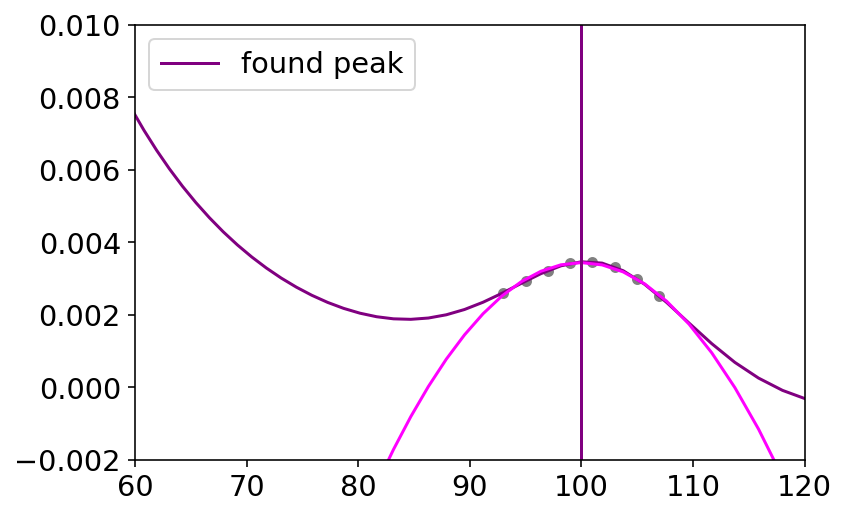

In [8]:
cat_tag = '_L750_n1e-4'
r_true, xi_true = load_true(cat_tag)
rpeak_guess = 100.0
bw = 2
r_peak_arr, r_points, xi_points, popt = find_peaks_center([r_true], [xi_true], rpeak_guess, bws=[bw], r_widths=[8.0])

plt.figure()
color = 'purple'
plt.plot(r_true, xi_true, color=color)
plt.plot(r_true, quadratic(r_true, *popt), color='magenta')
plt.scatter(r_points, xi_points, marker='o', s=20, color='grey')
plt.axvline(r_peak_arr[0], color=color, label='found peak')
r_max_true = r_peak_arr[0]
print("Found peak:", r_max_true)
plt.legend()
plt.xlim(60, 120)
plt.ylim(-0.002, 0.01)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0
Number of NaNs: 11 , Bottom edges: 1 , Top edges: 3
Number of NaNs: 3 , Bottom edges: 3 , Top edges: 2


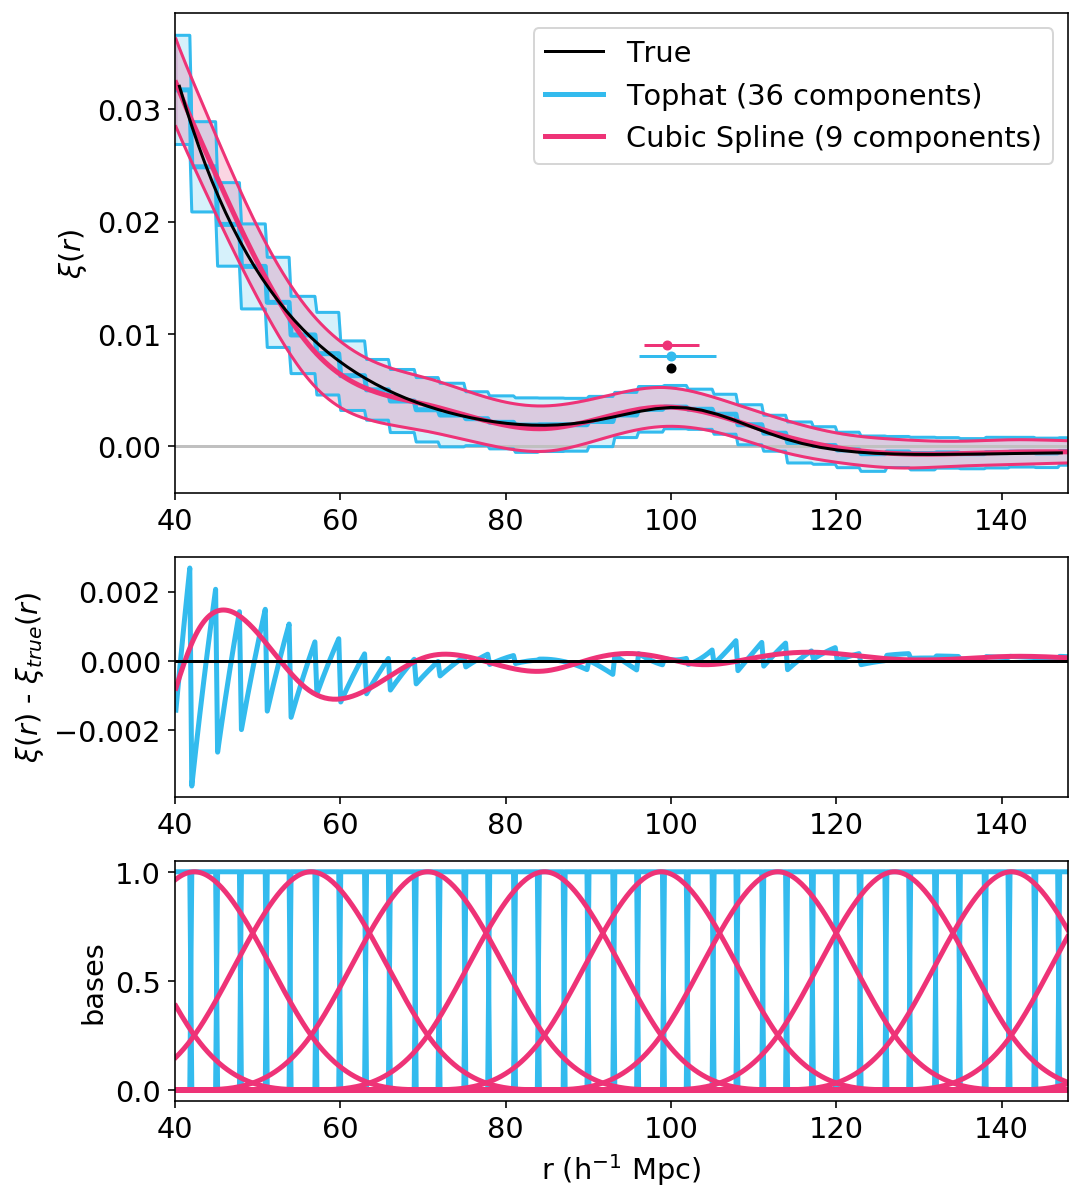

In [9]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw3', '_spline3_bw12']

colors = [ctopmany, cspline]
labels = ['Tophat (36 components)', 'Cubic Spline (9 components)']

ax, r_peaks = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=True, 
                              bws=[3,2], r_widths=[11.,8.], r_max_true=r_max_true)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0
Number of NaNs: 8 , Bottom edges: 5 , Top edges: 3
Number of NaNs: 3 , Bottom edges: 3 , Top edges: 2


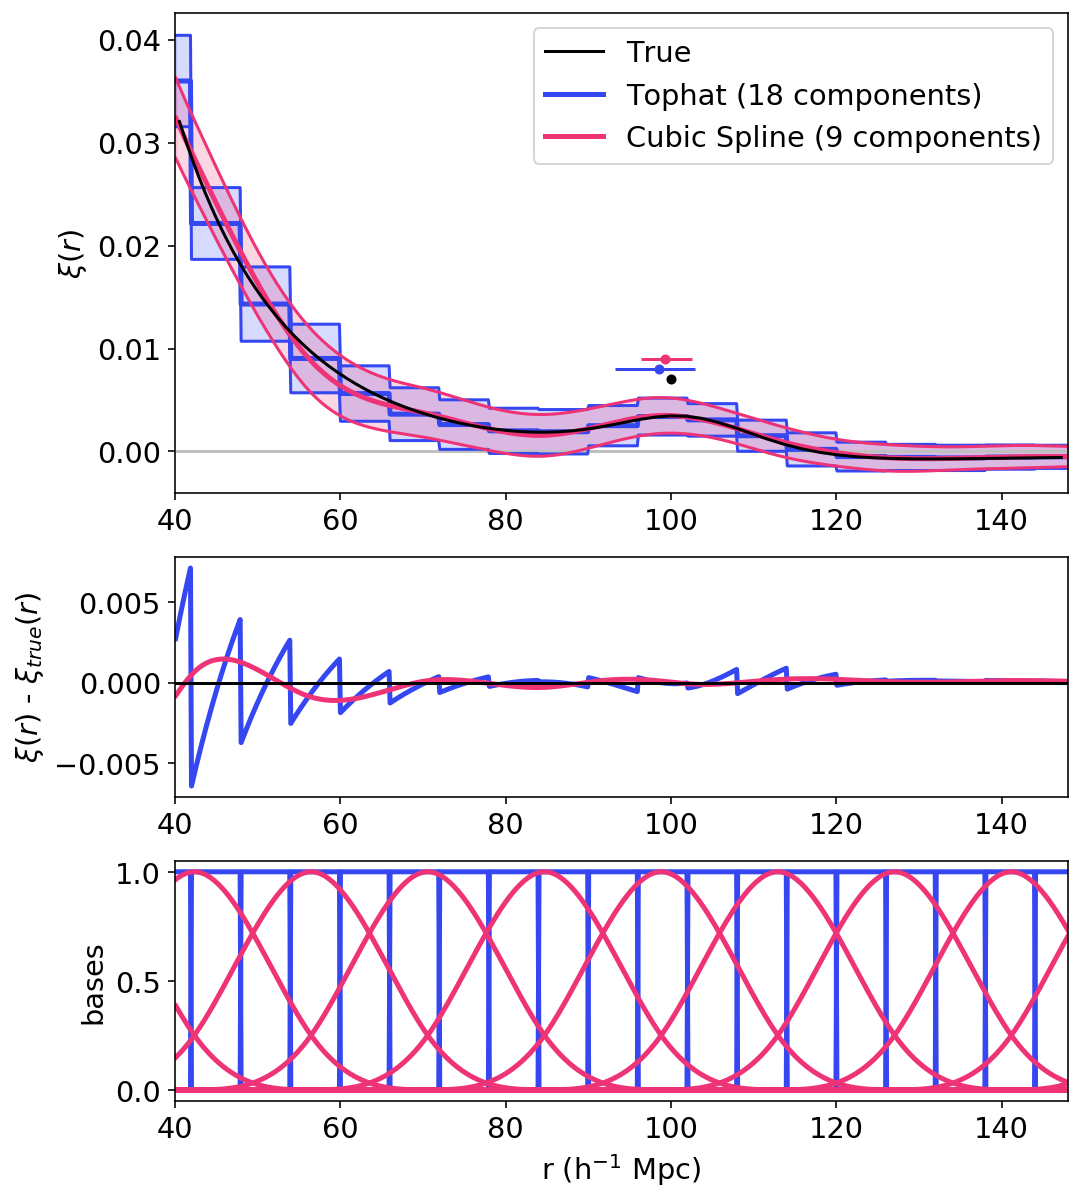

In [15]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw6', '_spline3_bw12']

colors = [ctopmid, cspline]
labels = ['Tophat (18 components)', 'Cubic Spline (9 components)']
ax, r_peaks = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=True, 
                              bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0
Number of NaNs: 4 , Bottom edges: 3 , Top edges: 0
Number of NaNs: 3 , Bottom edges: 3 , Top edges: 2


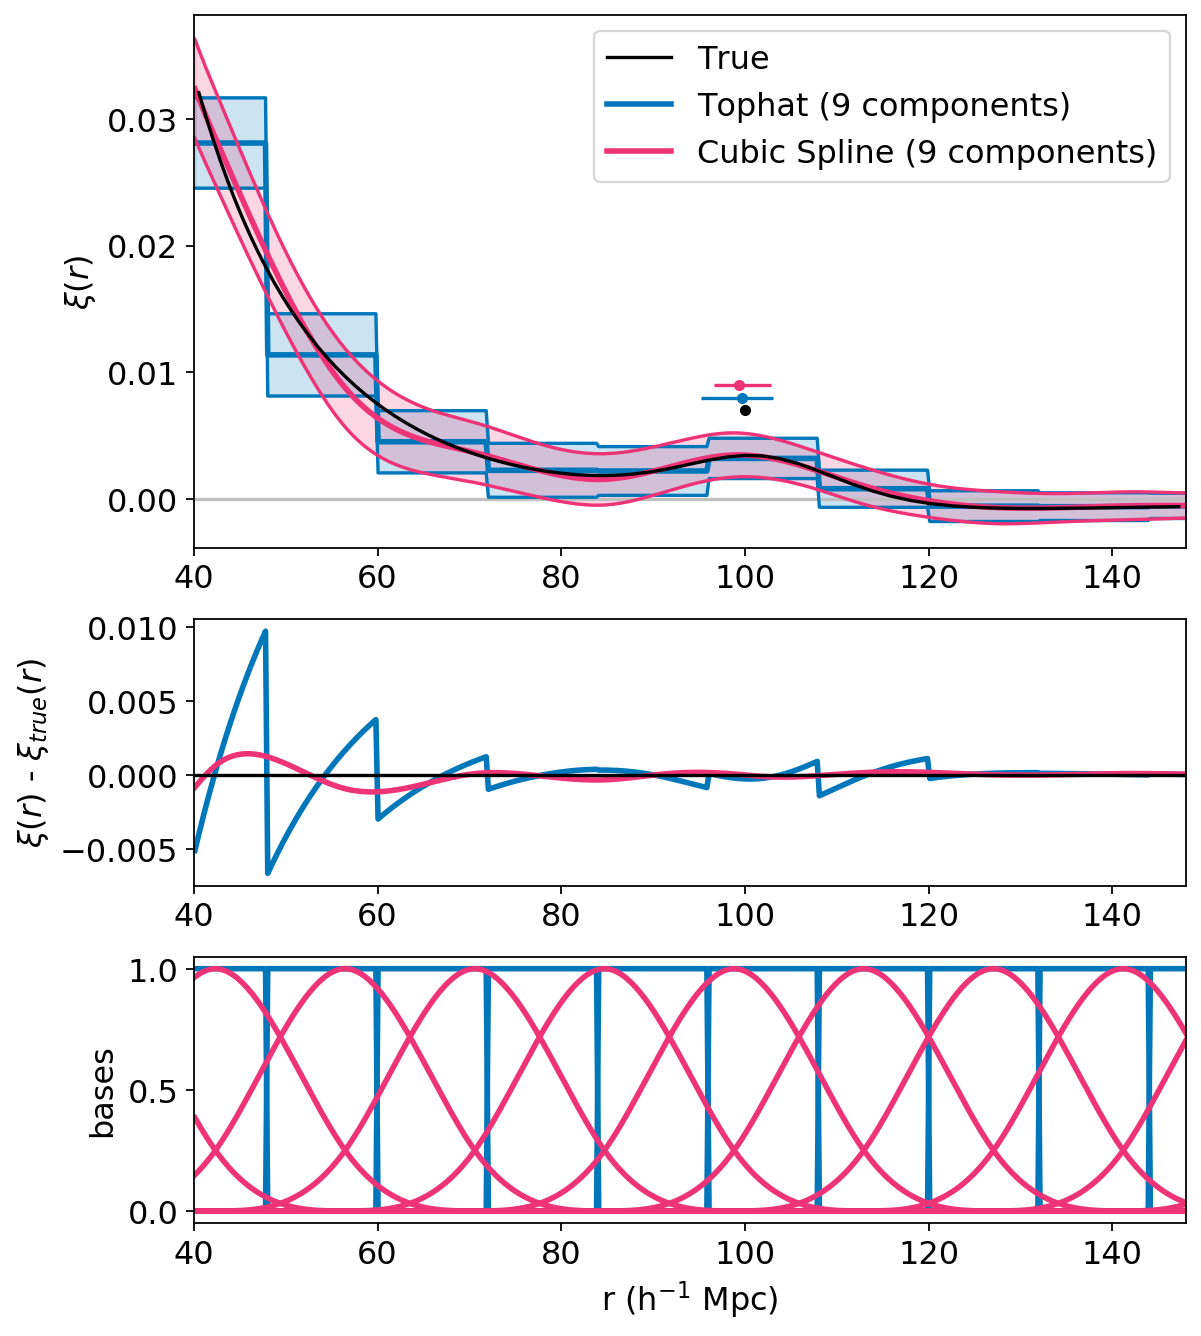

In [114]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw12', '_spline3_bw12']

colors = [ctopfew, cspline]
labels = ['Tophat (9 components)', 'Cubic Spline (9 components)']
ax, r_peaks = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=True, 
                              bws=[12,2], r_widths=[19.,8.], r_max_true=r_max_true)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0
Number of NaNs: 8 , Bottom edges: 5 , Top edges: 3
Number of NaNs: 5 , Bottom edges: 3 , Top edges: 2


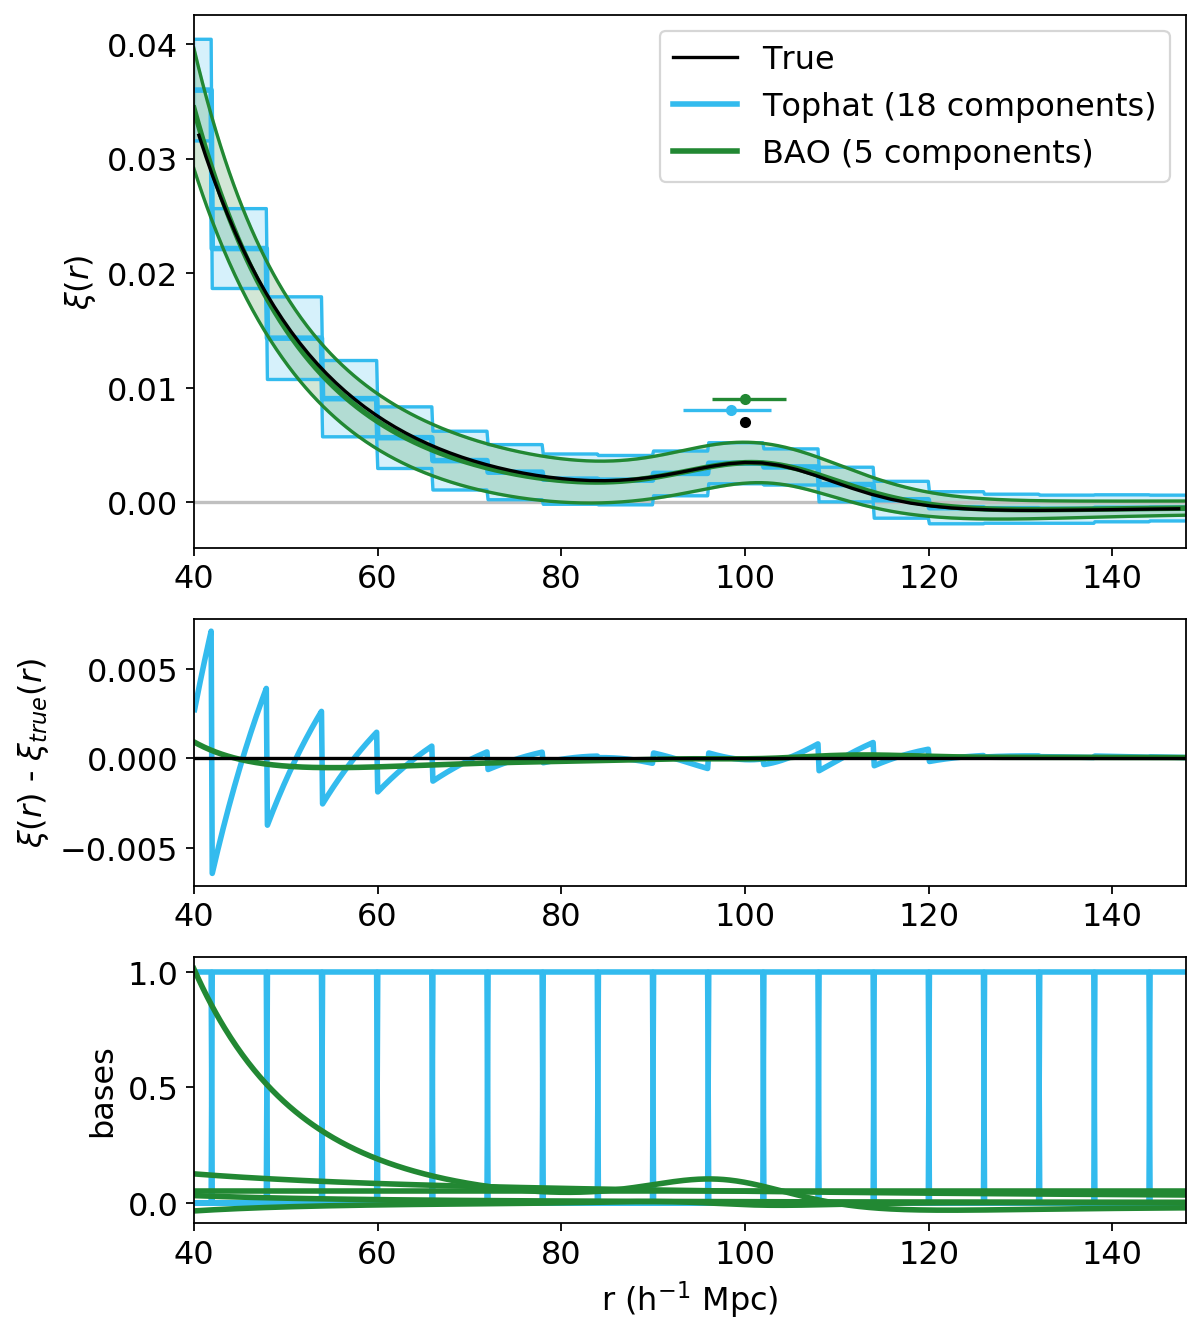

In [116]:
cat_tag = '_L750_n1e-4'
cf_tags = ['_tophat_bw6','_baoiter_cosmob17']

colors = [ctopmany, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']
ax, r_peaks = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=True, 
                              bws=[6,2], r_widths=[15.,8.], r_max_true=r_max_true)

In [53]:
cmap = 'RdBu'

In [78]:
cat_tag = '_L750_n1e-4'
cf_tag = '_theory_bw10'
rs, xis = load_data(cat_tag, cf_tag)
print(np.array(xis).shape)

(100, 16)


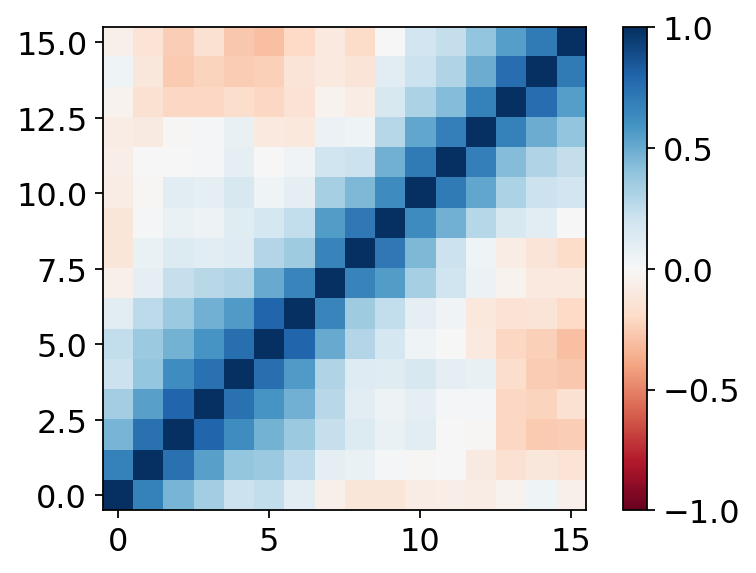

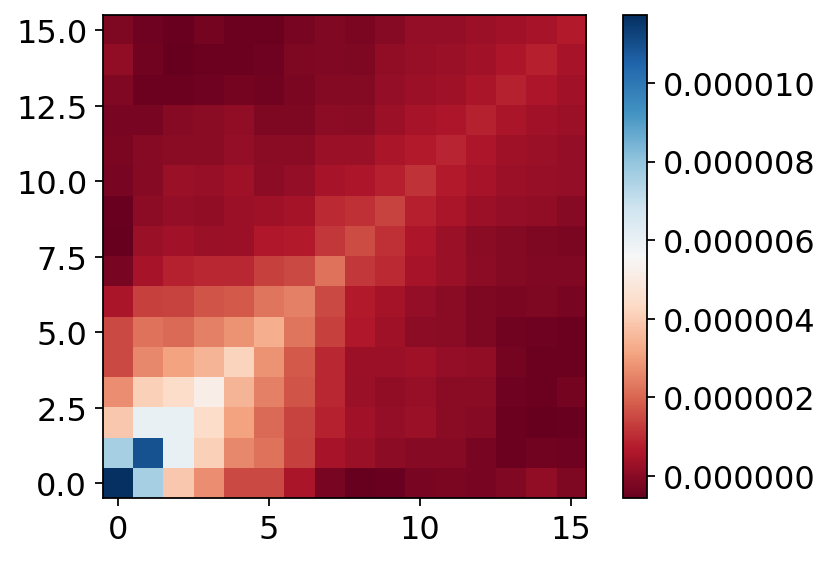

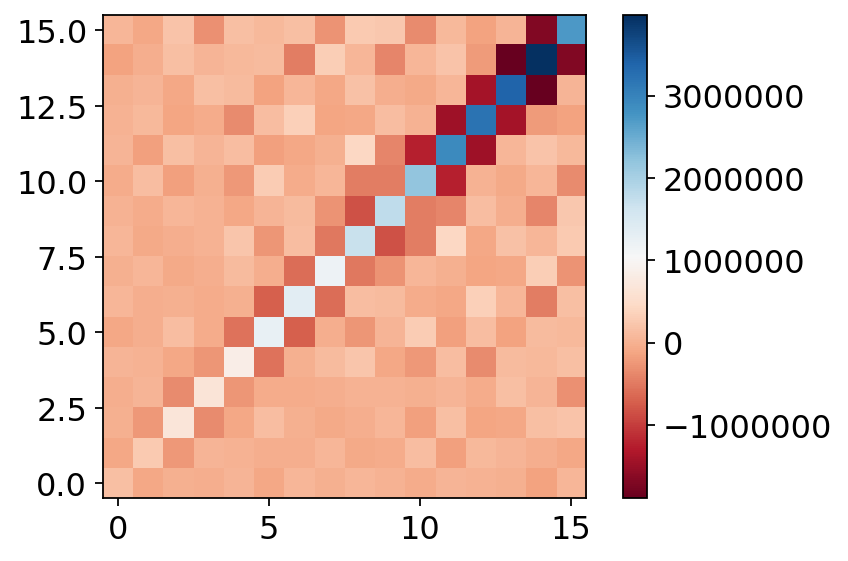

In [79]:
cov = utils.covariance(xis)
corr = utils.reduced_covariance(cov)
inv = utils.inverse_covariance(cov, len(xis))
invinv = utils.inverse_covariance(inv, len(xis))

plt.figure()
plt.imshow(corr, origin='lower left', cmap=cmap, vmin=-1, vmax=1)
plt.colorbar()
plt.figure()
plt.imshow(cov, origin='lower left', cmap=cmap)
plt.colorbar()
plt.figure()
plt.imshow(inv, origin='lower left', cmap=cmap)
plt.colorbar()

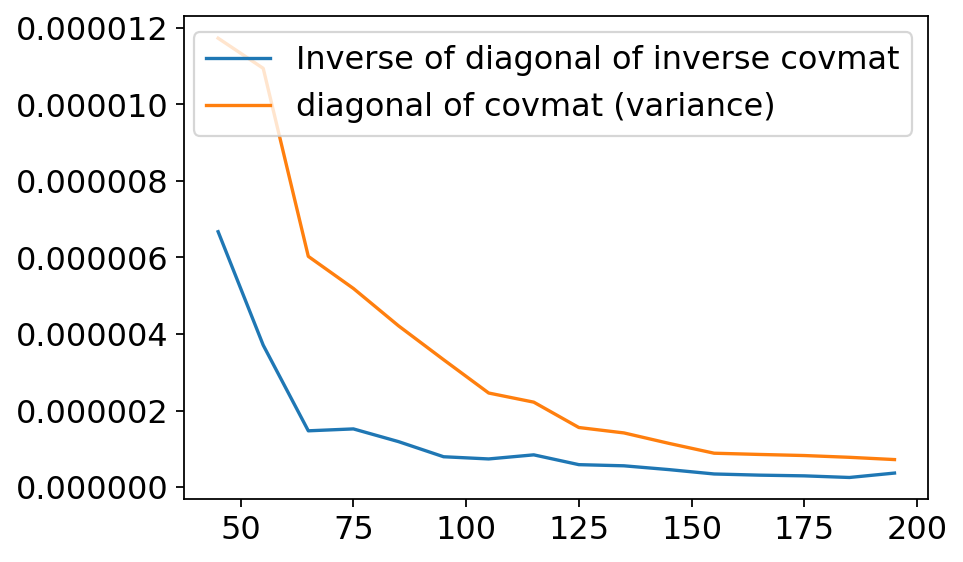

In [80]:
var = np.diag(cov)
invinv = 1./(np.diag(inv))
plt.plot(rs[0], invinv, label='Inverse of diagonal of inverse covmat')
plt.plot(rs[0], var, label='diagonal of covmat (variance)')
plt.legend()

In [97]:
cat_tag = '_L750_n1e-4'
cf_tag = '_baoiter_cosmob17'
rs, xis, amps = load_data(cat_tag, cf_tag, return_amps=True)
print(np.array(amps).shape)

(100, 5)


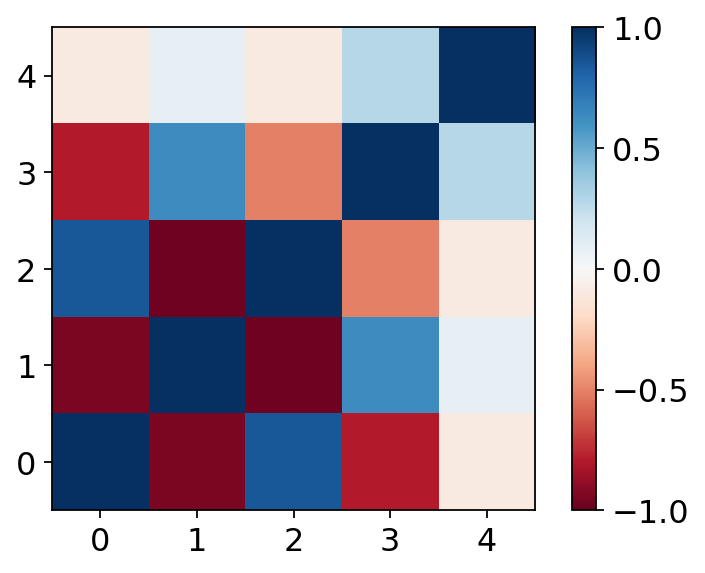

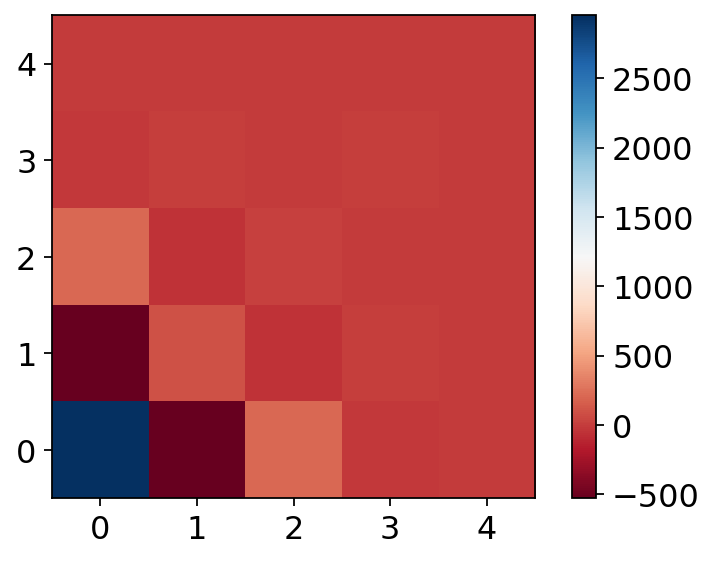

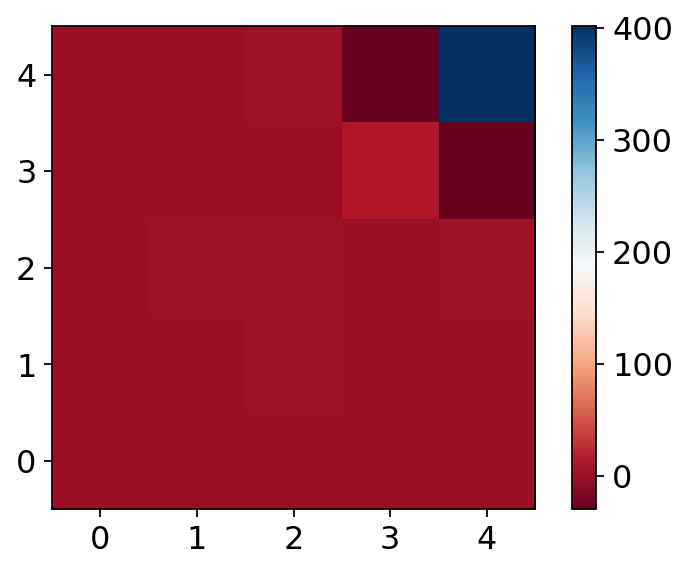

In [98]:
cov = utils.covariance(amps)
corr = utils.reduced_covariance(cov)
inv = utils.inverse_covariance(cov, len(amps))

plt.figure()
plt.imshow(corr, origin='lower left', cmap=cmap, vmin=-1, vmax=1)
plt.colorbar()
plt.figure()
plt.imshow(cov, origin='lower left', cmap=cmap)
plt.colorbar()
plt.figure()
plt.imshow(inv, origin='lower left', cmap=cmap)
plt.colorbar()

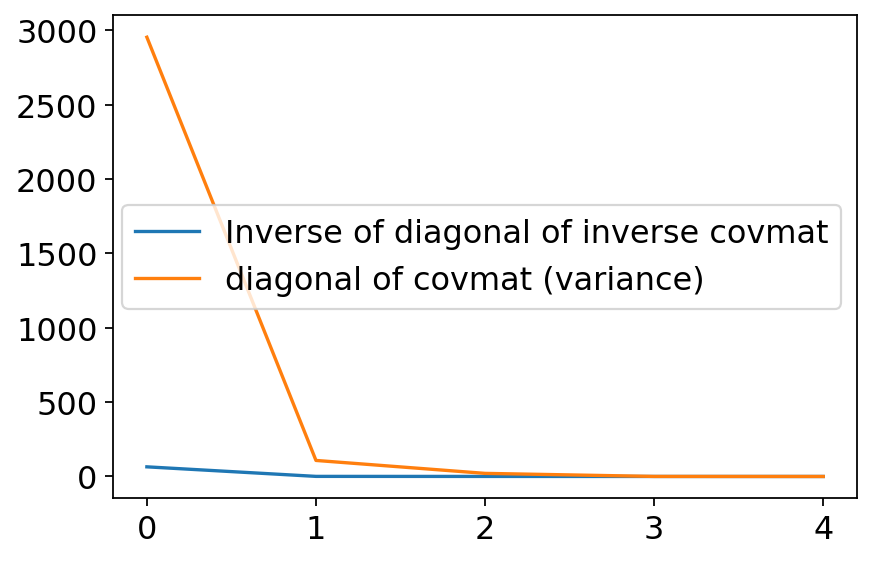

In [99]:
var = np.diag(cov)
invinv = 1./(np.diag(inv))
plt.plot(invinv, label='Inverse of diagonal of inverse covmat')
plt.plot(var, label='diagonal of covmat (variance)')
plt.legend()

Text(0.5, 0, 'r ($h^{-1}$Mpc)')

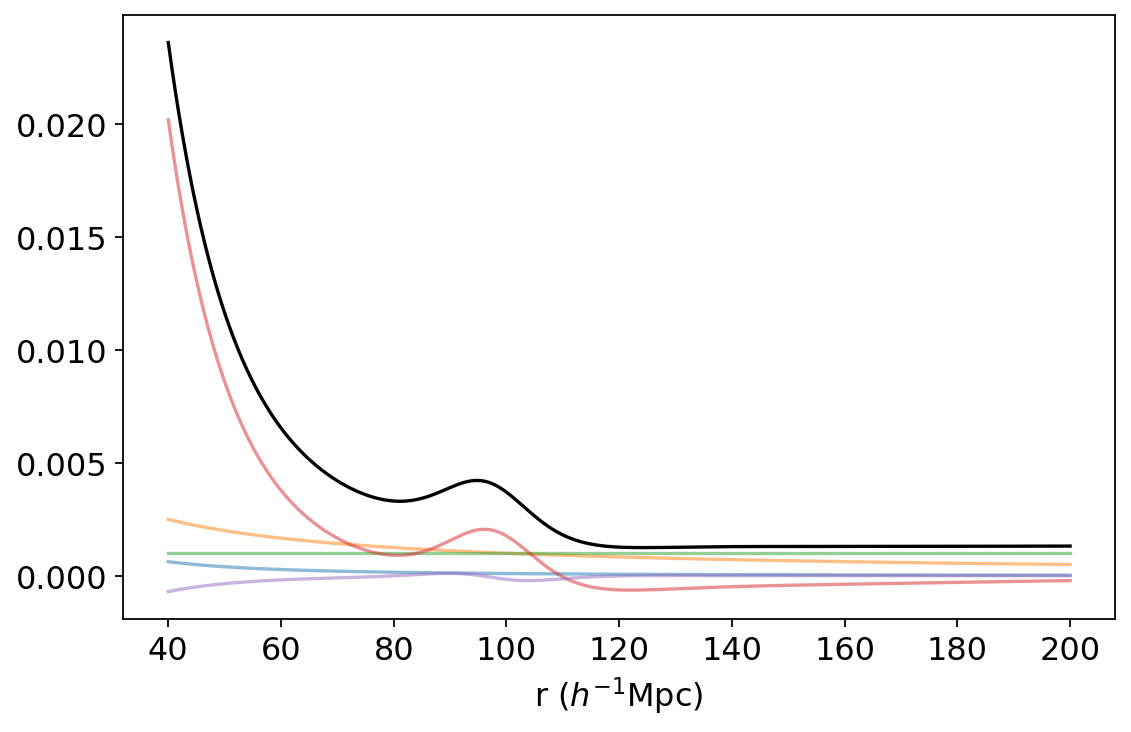

In [111]:
projfn = '../tables/bases_baoiter_cosmob17_L750_n1e-4.dat'
bases = np.loadtxt(projfn)
bases.shape
r = bases[:,0]
plt.figure(figsize=(8,5))
total = np.zeros(len(r))
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i], alpha=0.5)
    total += bases[:,i]
plt.plot(r, total, color='k')
plt.xlabel(r'r ($h^{-1}$Mpc)')

In [105]:
bases.shape

(1000, 6)

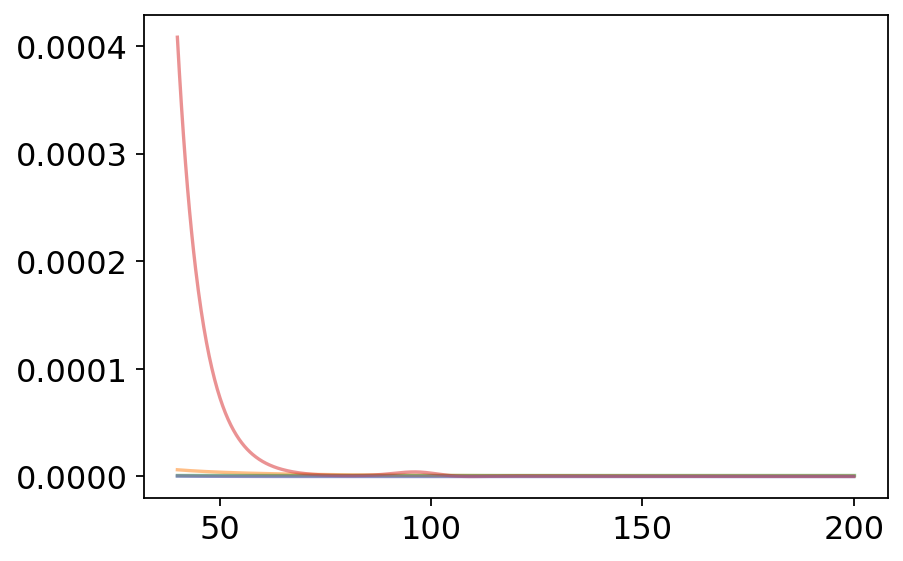

In [115]:
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i]**2, alpha=0.5)
#plt.plot(r, vartot, color='k')   

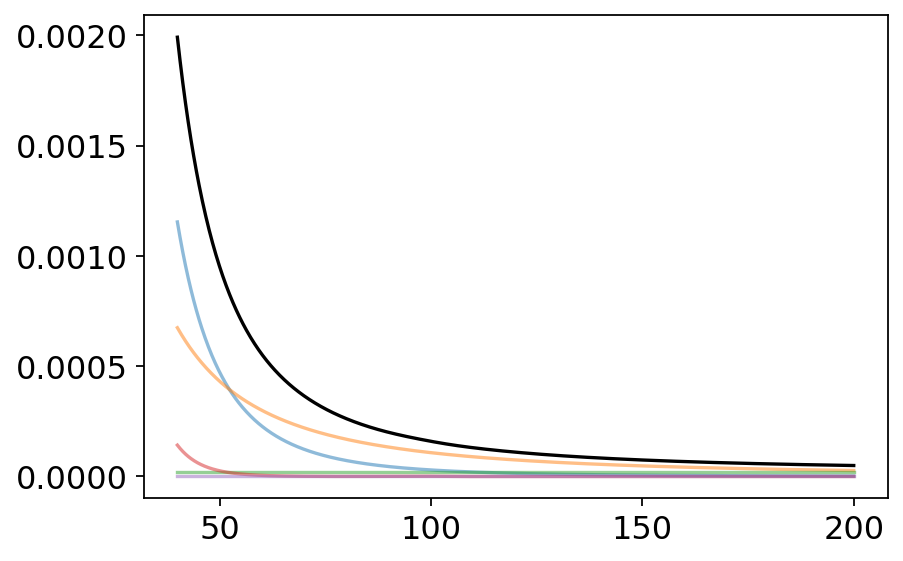

In [112]:
vartot = np.zeros(len(r))
#var = np.sqrt(var)
for i in range(1, len(bases[0])):
    plt.plot(r, var[i-1]*bases[:,i]**2, alpha=0.5)
    vartot += var[i-1]*bases[:,i]**2
plt.plot(r, vartot, color='k')   

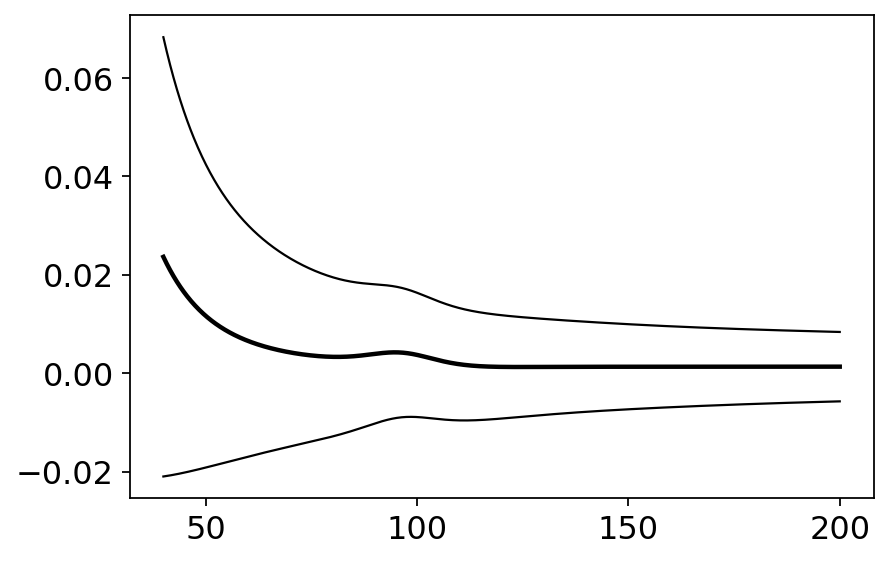

In [116]:
plt.plot(r, total, color='k', lw=2)  
plt.plot(r, total+np.sqrt(vartot), color='k', lw=1)  
plt.plot(r, total-np.sqrt(vartot), color='k', lw=1)  
#plt.ylim(-0.001, 0.01)

In [ ]:
vartot = np.zeros(len(r))
invinv = np.sqrt(var)
for i in range(1, len(bases[0])):
    plt.plot(r, var[i]*bases[:,i]**2, alpha=0.5)
    vartot += var[i]*bases[:,i]
plt.plot(r, vartot, color='k')   